# The SHIR model
by Ulf R. Pedersen

We wish to model the spread of an epidemic disease similar to the COVID-19 outbreak. It is assumed that a given individual can be in one of the following states:

* susceptible ($S$)
* infected healthy ($H$)
* ill ($I$)
* recovered ($R$)

The last category "recovered" makes no distinction between a dead or alive individuals. A few individuals will be infected without symptoms ($H$) in the initial state of the population, and the remaining individuals will be susceptible ($S$).

The state of the population progress in steps of one day using the below set of rules:

1. A infected healthy individual become ill.
2. A infected healthy individual recover.
3. A infected healthy individual infect a susceptible individual.
4. An ill individual recover (dead or alive).
5. An ill individual infect a susceptible individual.

The parameters, i.e. the probabilities of the events, are chosen to mimic a COVID-19 outbreak.

## Stochastic version of SHIR model
In the following, we will make a Monte Carlo simulation (with an extensive use of random numbers).
*Implementation notes:* We will use a list of string to describe the state of the system.

In [1]:
# Module with random numbers for Monte Carlo simulation
from numpy import random

# Simulation variables
total_number_of_days = 150

# Probabilities of rules (the letters referes to the names of the below ODE version of the model)
probability_healthy_infect = 1/3  # a_H
probability_ill_to_infect = 1/9   # a_I
probability_healthy_to_ill = 1/12 # b
probability_healthy_to_recovered = 1/9  # c_H
probability_ill_recover = 1/21  # c_I

# Initial state of the system
number_of_individuals = int(1e4)

def initial_state(number_of_individuals,number_of_sick_individuals_at_day_zero = 10):
    ''' Return the initial state of the system as a list of strings. '''
    individuals_today = []
    for index in range(number_of_individuals):
        if index < number_of_sick_individuals_at_day_zero:
            individuals_today.append('infected healthy')
        else:
            individuals_today.append('susceptible')
    return individuals_today

individuals_today = initial_state(number_of_individuals)

def the_next_day(individuals_today):
    ''' Update the state of the system by one day '''
    individuals_tomorrow = individuals_today.copy()
    for index, individual in enumerate(individuals_today):
        # Rule 1
        if individual == 'infected healthy' and random.rand() < probability_healthy_to_ill:
            individuals_tomorrow[index] = 'ill'
        # Rule 2
        if individual == 'infected healthy' and random.rand() < probability_healthy_to_recovered:
            individuals_tomorrow[index] = 'recovered'
        # Rule 3
        if individual == 'infected healthy' and random.rand() < probability_healthy_infect:
            random_index = random.randint(len(individuals_tomorrow))
            if individuals_tomorrow[random_index] == 'susceptible':
                individuals_tomorrow[random_index] = 'infected healthy'
        # Rule 4
        if individual == 'ill' and random.rand() < probability_ill_recover:
            individuals_tomorrow[index] = 'recovered'
        # Rule 5
        if individual == 'ill' and random.rand() < probability_ill_to_infect:
            random_index = random.randint(len(individuals_tomorrow))
            if individuals_tomorrow[random_index] == 'susceptible':
                individuals_tomorrow[random_index] = 'infected healthy'
    return individuals_tomorrow.copy()

list_susceptible = []
list_healthy = []
list_ill = []
list_recovered = []
for day in range(total_number_of_days):
    list_susceptible.append(individuals_today.count('susceptible'))    
    list_healthy.append(individuals_today.count('infected healthy'))
    list_ill.append(individuals_today.count('ill'))
    list_recovered.append(individuals_today.count('recovered'))
    individuals_today = the_next_day(individuals_today)

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

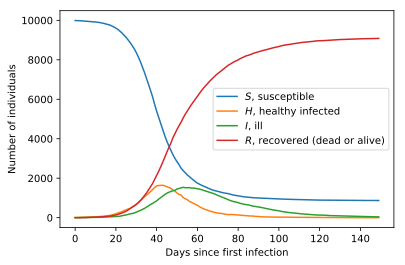

In [3]:
# Plot on a linear scale
plt.figure()
plt.plot(list_susceptible)
plt.plot(list_healthy)
plt.plot(list_ill)
plt.plot(list_recovered)
plt.xlabel('Days since first infection')
plt.ylabel('Number of individuals')
plt.legend(['$S$, susceptible','$H$, healthy infected','$I$, ill','$R$, recovered (dead or alive)'])
plt.show()

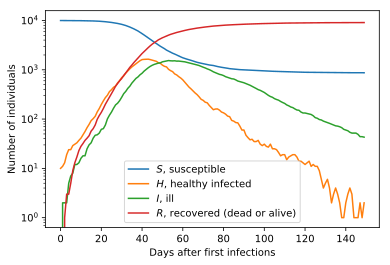

In [4]:
# Plot on a logaritmic scale
plt.figure()
plt.plot(list_susceptible)
plt.plot(list_healthy)
plt.plot(list_ill)
plt.plot(list_recovered)
plt.xlabel('Days after first infections')
plt.ylabel('Number of individuals')
plt.legend([r'$S$, susceptible','$H$, healthy infected','$I$, ill','$R$, recovered (dead or alive)'])
plt.yscale('log')
plt.show()

## ODE version of SHIR model
A continuous version of the the model can be written in differential form as
$$
 \dot S = -a_H HS - a_I IS
$$
$$
 \dot H = a_H HS + a_I HS - bH - c_H H
$$
$$
 \dot I = bH - c_I I
$$
$$
 \dot R = c_HH + c_II
$$
where the dots refers to a time derivatives.
We solve this set of ordinaty differential equations (ODE) numerically:

In [5]:
from scipy.integrate import ode

# Define model
def f(t, y, args):
    S, H, I, R = y
    a_H, a_I, b, c_H, c_I = args
    dS = -a_H*H*S-a_I*I*S
    dH = -dS-b*H-c_H*H
    dI = b*H-c_I*I
    dR = c_H*H+c_I*I
    return [dS, dH, dI, dR]
model = ode(f)
model.set_integrator('vode',method='bdf')

# Set parameters
a_H = 1/3
a_I = 1/9
b = 1/12
c_H = 1/9
c_I = 1/21
args = a_H, a_I, b, c_H, c_I
model.set_f_params(args)

# Set initial values
t=0
infected = 1e-3
y = 1-infected, infected, 0, 0
model.set_initial_value(y,t)

# Solve
t, S, H, I, R = [], [], [], [], []
for time in range(1,total_number_of_days+1):
    y = model.integrate(time)
    t.append(time)
    S.append(y[0])
    H.append(y[1])
    I.append(y[2])
    R.append(y[3])

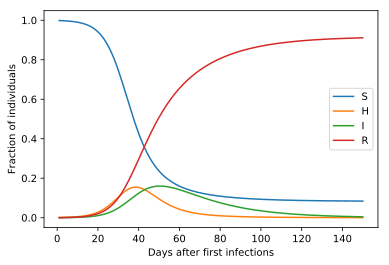

In [6]:
# Linear plot
plt.figure()
plt.plot(t,S)
plt.plot(t,H)
plt.plot(t,I)
plt.plot(t,R)
plt.xlabel('Days after first infections')
plt.ylabel('Fraction of individuals')
plt.legend('SHIR')
plt.show()

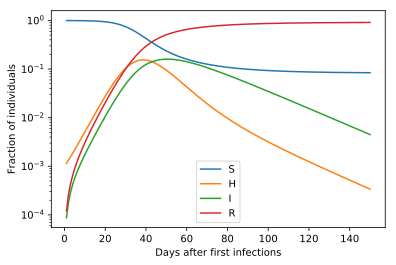

In [7]:
# logarithmic plot
plt.figure()
plt.plot(t,S)
plt.plot(t,H)
plt.plot(t,I)
plt.plot(t,R)
plt.xlabel('Days after first infections')
plt.ylabel('Fraction of individuals')
plt.legend('SHIR')
plt.yscale('log')
plt.show()

### Comparison of models

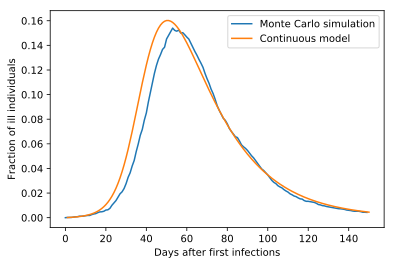

In [8]:
from numpy import array

plt.figure()
plt.plot(array(list_ill)/number_of_individuals,label='Monte Carlo simulation')
plt.plot(t,I,label='Continuous model')
plt.xlabel('Days after first infections')
plt.ylabel('Fraction of ill individuals')
plt.legend()
plt.show()

## The "shadow-fraction"
We define the shadow-factor $f$ as the ratio between "healty infected", $H$, and the total number of infected, $H+I$,
$$
  f = H/(H+I).
$$
The time evolution, $f(t)$, is shown below.

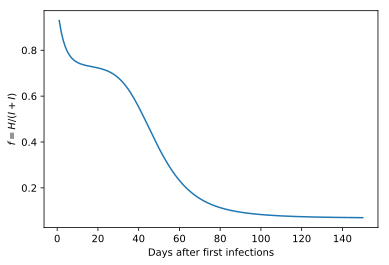

In [9]:
plt.figure()
plt.plot(t,array(H)/(array(I)+array(H)))
plt.xlabel('Days after first infections')
plt.ylabel('$f=H/(I+I)$')
plt.show()

The shadow-fraction $f$ is high in the initial phase of the outbreak, and low towards the end.